## Dataset Inspection

Dataset: McAuley-Lab/Amazon-Reviews-2023


In [1]:
!pip install -q -U python-dotenv huggingface-hub datasets matplotlib transformers

In [1]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict 
import matplotlib.pyplot as plt

from items import Item

/Volumes/VTG/Dev/C_5/Projects/week6/data_curation-optimization/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")

In [3]:
### Log in to HuggingFace

HF_TOKEN = os.getenv("HF_TOKEN")
login(HF_TOKEN, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
### Load dataset
cateogry = "Electronics"
dataset_base_path = f"https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/resolve/main/raw_meta_{cateogry}/"
num_files = 10

urls = [f"{dataset_base_path}full-0000{i}-of-00010.parquet" for i in range(num_files)]

dataset = load_dataset(
    "parquet",
    data_files=urls,
    split="train"
)

## Before Data Scrubbing

In [5]:
print("Number of Products: ", len(dataset))

Number of Products:  1610012


In [ ]:
print("TITLE:\n", dataset["title"])
print("======================================================================")
print("DESC:\n", dataset["description"])
print("======================================================================")
print("FEATURES:\n", dataset["features"]) 
print("======================================================================")
print("DETAILS:\n", dataset["details"]) 
print("======================================================================")
print("PRICE:\n", dataset["price"])

In [7]:
### How many have price info? 
# counts only datapoints that have the price label with actual float value.
# If "none", "N/A", ""(empty string) or any value mismatch, it ddirects it to
# the except block

prices = 0
for datapoint in dataset["price"]: 
    try:
        if datapoint is not None and float(datapoint) > 0: 
            prices += 1
    except (ValueError, TypeError) as e:
        continue

print(f"There are {prices:,} products with the price tag, which is {(prices / len(dataset)) * 100:,.1f}% out of the total properties.")


There are 526,439 products with the price tag, which is 32.7% out of the total properties.


In [8]:
### 1. Average Price (only for those that have price info)
price_list = []

for datapoint in dataset["price"]:
    try: 
        if datapoint is not None and float(datapoint) > 0:
            price_list.append(float(datapoint))

    except (ValueError, TypeError) as e: 
        continue

avg_price = sum(price_list) / len(price_list)
print(f"Average Price: ${avg_price:,.2f} (USD)")

Average Price: $96.46 (USD)


In [9]:
### 2. Average Text Length Per Item (for those with the price tag)

num_words_list = []

for datapoint in dataset: 
    try: 
        price = float(datapoint["price"]) 
        if price > 0 and datapoint["description"]: 

            for desc in datapoint["description"]: 
                num_words = len(desc.split(" "))
                num_words_list.append(num_words)
            
    except (ValueError, TypeError): 
        continue


In [10]:
avr_words_len = sum(num_words_list) / len(num_words_list)
print(f"Avg Word Count: {avr_words_len:.2f}")

highest_words_len = max(num_words_list)
print(highest_words_len)

Avg Word Count: 24.57
8285


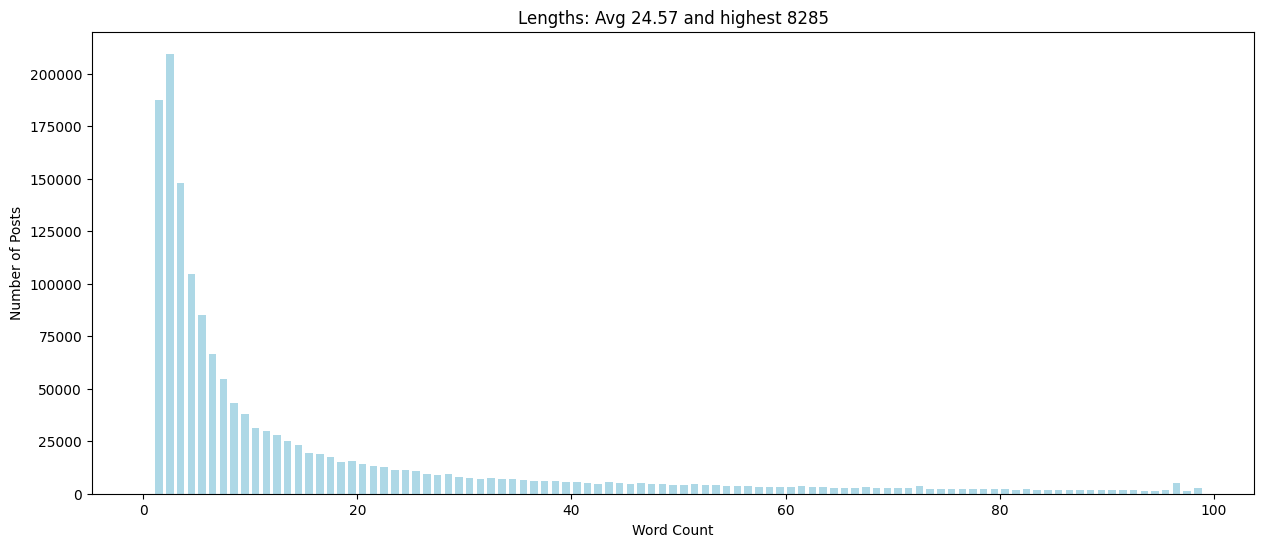

In [11]:
### Plot the distribution of lengths

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {avr_words_len:.2f} and highest {max(num_words_list)}")
plt.xlabel("Word Count")
plt.ylabel("Number of Posts")
plt.hist(num_words_list, rwidth=0.7, color="lightblue", bins=range(0, 100, 1))
plt.show()

(array([1.0297e+04, 9.3709e+04, 7.8563e+04, 6.5807e+04, 3.3754e+04,
        3.2299e+04, 1.7440e+04, 2.1243e+04, 9.2610e+03, 1.5053e+04,
        6.9490e+03, 1.0418e+04, 4.8070e+03, 8.5390e+03, 3.9350e+03,
        6.9090e+03, 2.8320e+03, 5.5680e+03, 2.1100e+03, 6.7060e+03,
        1.4550e+03, 3.1800e+03, 1.5050e+03, 3.5090e+03, 1.4400e+03,
        3.9060e+03, 1.1550e+03, 2.9650e+03, 1.0520e+03, 3.5080e+03,
        9.2800e+02, 2.3370e+03, 8.0100e+02, 2.4130e+03, 7.5100e+02,
        2.1600e+03, 6.4400e+02, 1.8280e+03, 6.1500e+02, 3.4720e+03,
        4.7300e+02, 9.4300e+02, 4.4300e+02, 1.3060e+03, 5.2100e+02,
        1.4260e+03, 4.1500e+02, 1.0470e+03, 3.7400e+02, 1.8040e+03,
        3.7000e+02, 9.1100e+02, 3.4900e+02, 8.8800e+02, 2.8600e+02,
        1.0040e+03, 3.1500e+02, 7.6400e+02, 3.0700e+02, 2.2300e+03,
        2.5600e+02, 4.2900e+02, 2.1700e+02, 5.7700e+02, 2.2000e+02,
        7.3400e+02, 1.8900e+02, 4.8400e+02, 2.0900e+02, 1.1000e+03,
        2.3100e+02, 4.6300e+02, 1.5400e+02, 4.75

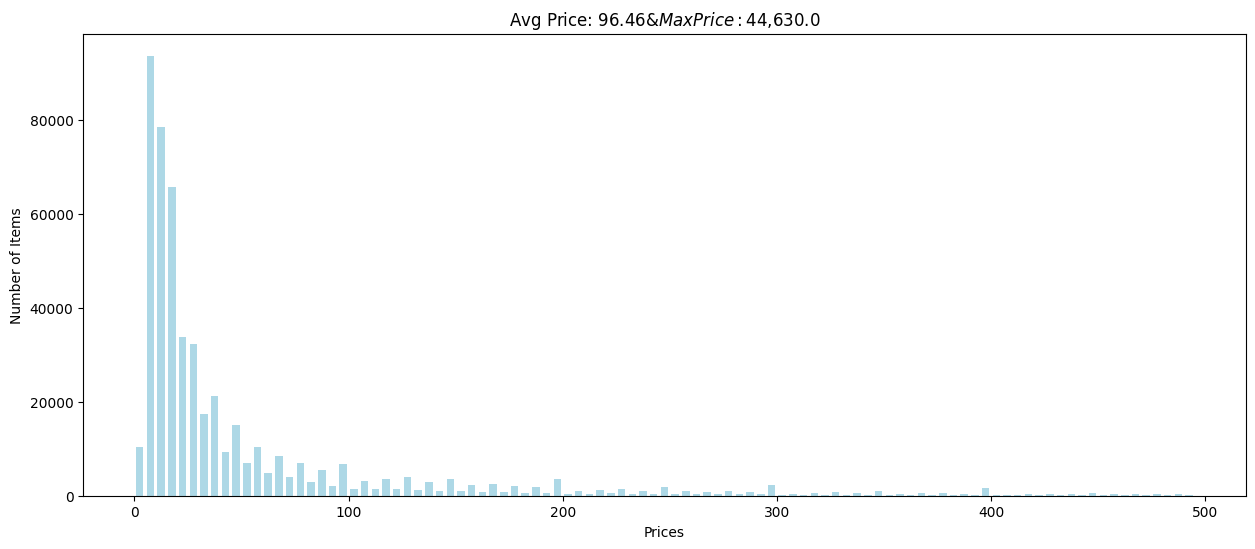

In [12]:
### Plot the distribution of prices

plt.figure(figsize=(15, 6))
plt.title(f"Avg Price: ${avg_price:,.2f} & Max Price: ${max(price_list):,}")
plt.xlabel("Prices")
plt.ylabel("Number of Items")
plt.hist(price_list, rwidth=0.7, color="lightblue", bins=(range(0, 500, 5)))

In [13]:
### Find the item with the highest price: 
prices = []
for datapoint in dataset: 
    try:
       if float(datapoint["price"]) > 44000:
           print(datapoint["title"])
    except ValueError: 
        continue    

Dell PowerEdge C6320 24B 8X E5-2620 V4 8-Core 2.1Ghz 2048GB 24x 1.6TB SSD H330 (Renewed)


In [14]:
print(dataset[529]["details"])

{"Product Dimensions": "22.44 x 3.54 x 13.74 inches", "Item Weight": "3 pounds", "Manufacturer": "Netgear", "Language": "English", "Item model number": "XS708E-100NES", "Best Sellers Rank": {"Computer Networking Switches": 4075}, "Is Discontinued By Manufacturer": "No", "Date First Available": "February 7, 2013"}


## Curate Dataset (After Scrubbing)

In [5]:
### Create an Item object for each product with price:
valid_items = []

for datapoint in dataset: 
    try:
        price = float(datapoint["price"])
        if price > 0:
            item = Item(datapoint, price)
            # Only the items with include set to True
            if item.include:
                valid_items.append(item)
    except ValueError: 
        continue

In [6]:
print(len(valid_items))

485415


In [7]:
### Check Points:
# - prompt created via parse() method
# - prompt used for duing training time (because the price is revealed)

print(valid_items[100].prompt)

How much does this cost to the nearest dollar?

Airpods Case, Airpods Accessories Kits, 2 Pack Protective Silicone Cover Apple Airpods Anti-Lost Airbag Belt, for Apple AirPods 2nd 1st Generation (Black+White)
offers 100% Satisfaction Guarantee -180 days money back and lifetime technique support. Airpods Case, Airpods Accessories Kits, 11 in 1 Protective Silicone Cover and Skin for Apple Airpods with Anti-lost Airpods Strap, Airpods Watch band Holder, Airpods Ear Hook  Airpods Case is made from premium quality silicone material. Shock & Dust Resistant, Friendly to skin, Durable, Flexible, Portable and Lightweight. No need to worry about the apple airpods will loss! Perfects for gym, exercise,

Price is $13.00


In [10]:
### During test time:

print(valid_items[100].test_prompt())

How much does this cost to the nearest dollar?

Airpods Case, Airpods Accessories Kits, 2 Pack Protective Silicone Cover Apple Airpods Anti-Lost Airbag Belt, for Apple AirPods 2nd 1st Generation (Black+White)
offers 100% Satisfaction Guarantee -180 days money back and lifetime technique support. Airpods Case, Airpods Accessories Kits, 11 in 1 Protective Silicone Cover and Skin for Apple Airpods with Anti-lost Airpods Strap, Airpods Watch band Holder, Airpods Ear Hook  Airpods Case is made from premium quality silicone material. Shock & Dust Resistant, Friendly to skin, Durable, Flexible, Portable and Lightweight. No need to worry about the apple airpods will loss! Perfects for gym, exercise,

Price is $


In [8]:
### From __repr__ of the Item class:

print(valid_items[100])

<Airpods Case, Airpods Accessories Kits, 2 Pack Protective Silicone Cover Apple Airpods Anti-Lost Airbag Belt, for Apple AirPods 2nd 1st Generation (Black+White) = $12.99>


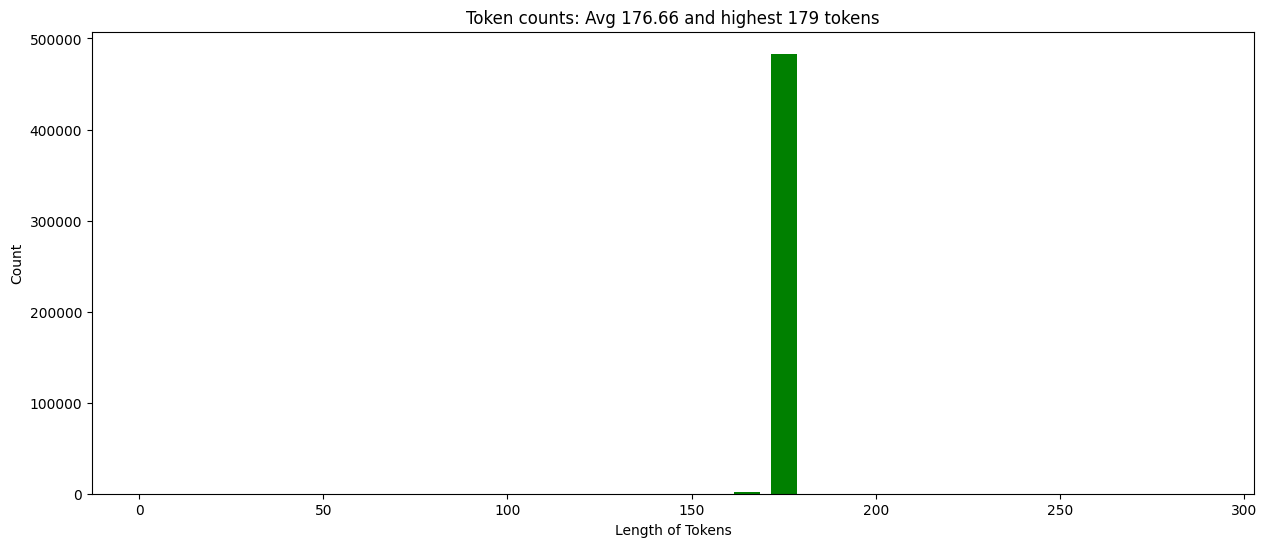

In [21]:
### Plot the distribution of token counts:

tokens = [item.token_count for item in valid_items] 
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens) / len(tokens):.2f} and highest {max(tokens)} tokens")
plt.xlabel("Length of Tokens")
plt.ylabel("Count")
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

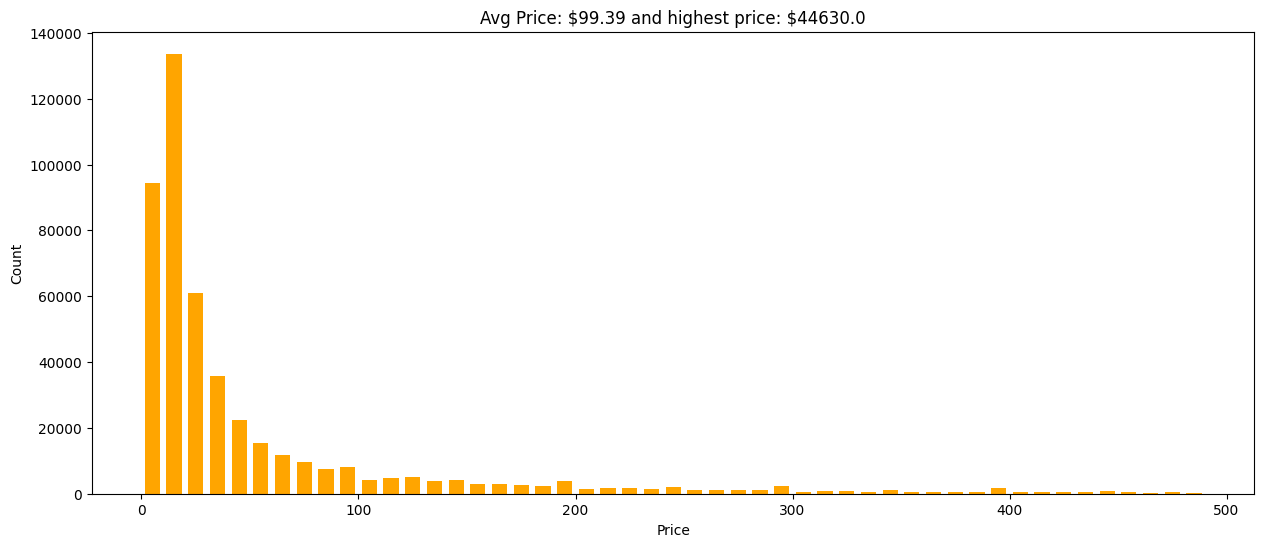

In [22]:
### Plot the distribution of prices:

prices = [item.price for item in valid_items]
plt.figure(figsize=(15, 6))
plt.title(f"Avg Price: \\${sum(prices) / len(prices):.2f} and highest price: \\${max(prices)}")
plt.xlabel("Price") 
plt.ylabel("Count")
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 500, 10))
plt.show()

MIN:  154
MAX:  1264
AVG:  719.3701018715944


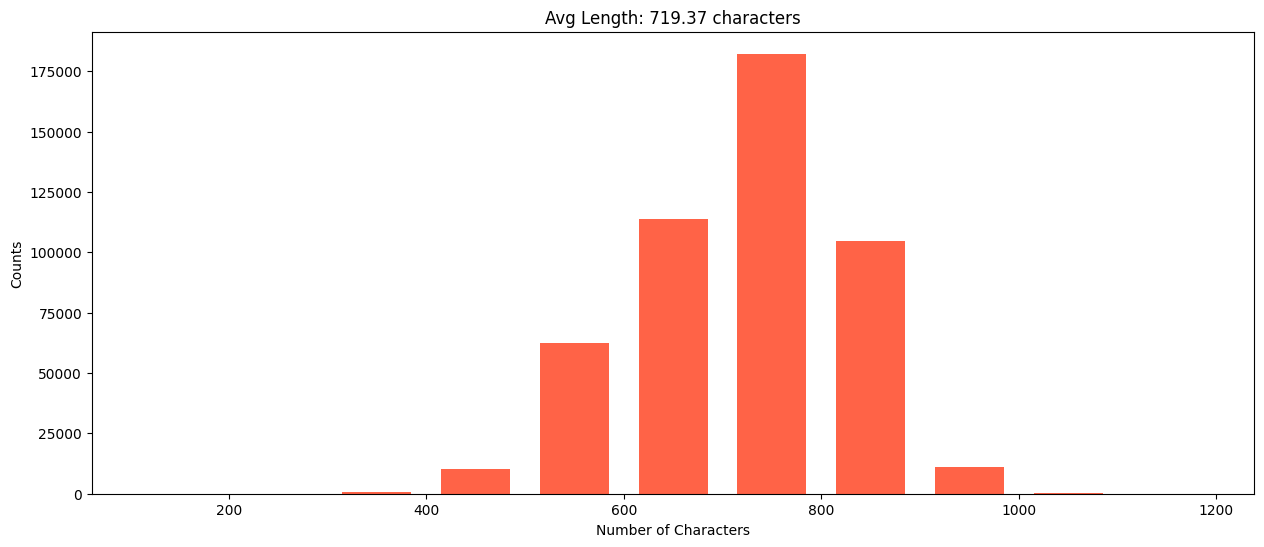

In [42]:
### Plot the average char length of products:

length = [len(item.prompt) for item in valid_items]

print("MIN: ", min(length))
print("MAX: ", max(length))
print("AVG: ", sum(length) / len(length))

plt.figure(figsize=(15, 6))
plt.title(f"Avg Length: {sum(length) / len(length):.2f} characters")
plt.xlabel("Number of Characters")
plt.ylabel("Counts")
plt.hist(length, rwidth=0.7, color="tomato", bins=range(100, 1300, 100))
plt.show()